# Modelling - Insurance App Ratings on Google Play Store

In this notebook, we will
1. select an appropriate __evaluation matrix__
2. devise our __modelling and validation strategy__
3. select the __best model__ and
4. share __actionable business insights__

In [1]:
import pandas as pd
import numpy as np
import time
import string
from datetime import datetime
from pathlib import Path
import re
from scipy.stats import loguniform
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from nltk import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

plt.style.use('fivethirtyeight')

random_seed = 79

In [2]:
train_review = '../data/interim/train_review.csv'
df_train = pd.read_csv(train_review)
df_train.shape

(7980, 14)

In [3]:
test_review = '../data/interim/test_review.csv'
df_test = pd.read_csv(test_review)
df_test.shape

(2660, 14)

In [4]:
df_train.head()

,reviewId,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appId,company,year,rating,clean_review,clean_review_len
0,gp:AOqpTOFZYnapoEKajsEGFrCKJ_vmsJ8If4t6mZ5K6xt...,After update my existing policies are not show...,1,0,4.9,2019-10-28 20:49:10,"Hi,\nWe are sorry for the inconvenience caused...",2019-10-29 09:26:51,com.ba.cp.controller,bajaj_allianz,2019,1,update exist policy not show full bug,7
1,gp:AOqpTOHy0QfB7Y5Uj98Kw7F-iRhMZGUeYNw81fR8ZFW...,Tiring. Just keeps icon rotating. Nothing happ...,1,0,7.7,2021-04-10 15:04:07,"Hi Sharad Thombre, We apologize for the inconv...",2021-04-21 10:31:33,com.pms.activity,hdfc_ergo,2021,1,tire keep icon rotate nothing happen wastage time,8
2,gp:AOqpTOGutSpa6ZgezQpU9b58sHejnifKFX_91Qa2SoQ...,"Now it's working properly, thanks",4,0,2.0.17,2021-02-03 15:02:58,"Dear Deepak, thanks for your feedback and we v...",2021-02-04 16:10:40,icici.lombard.ghi,icici_lombard,2021,0,work properly thank,3
3,gp:AOqpTOErT-CbrKgwZlpEKMUBuzlqSlQ5OhR8QOAgA39...,ICICI people ask us to raise the claim through...,1,0,2.0.27,2021-04-14 15:37:37,"Dear Bhushan, we apologize for the inconvenien...",2021-04-14 20:09:17,icici.lombard.ghi,icici_lombard,2021,1,people ask raise claim app app crash continuou...,13
4,gp:AOqpTOE_fRyh1_FEiWVfsG5qCw72bRHskVmI1jwLyNY...,Shaheen explained the app well ..easy to use a...,5,2,2.0.34,2021-06-20 22:18:43,"Dear Ruchika, Thank you so much for your valua...",2021-06-21 19:54:40,icici.lombard.ghi,icici_lombard,2021,0,shaheen explain app well easy use various faci...,12


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7980 entries, 0 to 7979
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              7980 non-null   object
 1   review                7980 non-null   object
 2   score                 7980 non-null   int64 
 3   thumbsUpCount         7980 non-null   int64 
 4   reviewCreatedVersion  6944 non-null   object
 5   at                    7980 non-null   object
 6   replyContent          6047 non-null   object
 7   repliedAt             6047 non-null   object
 8   appId                 7980 non-null   object
 9   company               7980 non-null   object
 10  year                  7980 non-null   int64 
 11  rating                7980 non-null   int64 
 12  clean_review          7980 non-null   object
 13  clean_review_len      7980 non-null   int64 
dtypes: int64(5), object(9)
memory usage: 872.9+ KB


For modelling purpose, we are mainly interested in rating, clean review text and company columns.

In [6]:
df_train = df_train[['rating','clean_review','company']]
df_test = df_test[['rating','clean_review','company']]

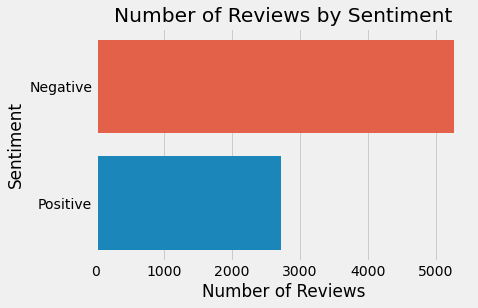

In [7]:
map_sentiment = {0:'Positive', 1:'Negative'}


ax = sns.countplot(y='rating', data= df_train)
ax.set_yticklabels(map_sentiment.values())
ax.invert_yaxis()
plt.ylabel('Sentiment')
plt.xlabel('Number of Reviews')
plt.title('Number of Reviews by Sentiment');

We have 66% negative sentiments and 34% positive sentiments.

## Evaluation matrix

For the GI industry, it is important to increase the adaptation and usage of mobile applications. We are more interested in understanding __what kind of application features or customer services are driving positive or negative sentiments__. We have seen that 40% of customers are not happy with mobile apps. This is a huge number. Hence, our __primary focus will be negative sentiment__. Given this business objective, we will be __using the pr_auc__ matrix as it gives more importance to positive class which in our case is negative sentiment.

## Modelling strategy

We are more interested in interpretation and insights. Hence, we consider following algorithms for our classification task. 


### Modelling :

1. __Logistic Regression with l1 regularization__ - Logistic regression is a simple linear algorithm with decent performance. We will use l1 regularization for feature selection. This will also be our base model.
2. __MultinomialNB Bayes__ - MultinomialNB Bayes is well suited for text classification task with discrete features.
2. __XgBoost__ - XgBoost is known to outperform linear models in many competitions.

### Validation :

We will use a __3-fold__ cross-validation strategy on train data for hyperparameter tuning and model selection. We will train these models on same set train-validation datasets. To select the best hyperparameters, we will use __RandomSearchCV__ technique. 

And finally, we will test the performance of the best model on the test dataset. This will give us a better idea of how well the model performs on unseen data.

### Process

In [8]:
num_folds = 3
cv = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=random_seed)

In [9]:
y_train = df_train['rating']

We will use company as a feature because we are more interested in industry level issues. With this dummmy, we will control for comapny specific issues. Converting company feature to dummies.

In [10]:
df_dummy_company = pd.get_dummies(df_train['company'],columns = ['company'])

### Logistic Regression

In [11]:
classifier_lr = LogisticRegression(penalty='l1', solver = 'saga', 
                                   max_iter=500, tol = 1e-2, 
                                   random_state=random_seed)

param_dists = { 'C': [0.1] }

lr_iterations = 1

### Feature Extraction : 
For feature extraction from text, we will use CountVectorizer & TfIdf Vectorizer.

#### Count Vectorizer

Below words do not contain any insights and they are coming as important features in our classification task. Hence, we will remove these words. This will somewhat affect our prediction performance. But we are more interested in interpretation and insights than predictions.

In [12]:
stop_words = ['no','not','nt','even','try','really','within','poor','useful', 'jinn',
              'hello','ever','waste','awesome', 'amazing', 'wrost','useless']
# jinn is the name of the application

We will first find the suitable minimum document frequency(min_df) using logistic regression. Then tune the parameters of different algorithms.

In [13]:
def text_vectorize(text, tfidf = False, min_df = 5, ngram_range = (1,3)):
    """
    derives features from text data
    
    text - text column df series
    tfidf - True for tfidf vectorized data. If False, function returns count vectorized data
    min_df, ngram_range - parameters for vectorizers
    
    df_txt_features - returns dataframe with text features as columns
    """
    
    if tfidf == False :
        vec = CountVectorizer(stop_words = stop_words,
                              min_df= min_df, 
                              ngram_range= ngram_range)
    else :
        vec = TfidfVectorizer(stop_words = stop_words,
                              min_df = min_df,
                              ngram_range = ngram_range,
                              smooth_idf=1,
                              sublinear_tf=1)
    

    X = vec.fit_transform(text)
    df_txt_features = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
    
    
    return df_txt_features
                                          

Finding optimum min_df for count vectorizer.

In [14]:
min_df_range = [5,10,20,40,80,160]

best_result = 0
results = []
best_params = None

for min_df in min_df_range:
    
    df_txt_cv_feat = text_vectorize(df_train['clean_review'], 
                                     tfidf = False,
                                     min_df= min_df, 
                                     ngram_range = (1,4))
    
    X_train = pd.concat([df_txt_cv_feat, df_dummy_company], axis =1)
    
    cv_lr = RandomizedSearchCV(classifier_lr, 
                           param_distributions=param_dists, 
                           scoring = 'average_precision',
                           n_iter=lr_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)
    
    cv_lr.fit(X_train, y_train)
    
    results.append(cv_lr.best_score_)
    
    if  cv_lr.best_score_ > best_result:
        
        best_result = cv_lr.best_score_ 
        best_params = min_df

print(results)
print('Best score is {} & associated best parameter is {}'.format(best_result,best_params))

[0.9262952667839147, 0.9266864952372322, 0.9272212190697703, 0.9315015200520116, 0.9342909156092102, 0.9313188232909585]
Best score is 0.9342909156092102 & associated best parameter is 80


0.93433 seems to be a good score with __best min_df at 80__ for count vectorizer. 

#### TfIdf vectorizer

Similarly, we find optimum minimun document frequency(min_df) using logistic regression for tfidf vectorizer.

In [15]:
min_df_range = [5,10,20,40,80,160]

best_result_tfidf = 0
results_tfidf = []
best_params_tfidf = None

for min_df in min_df_range:
    
    df_txt_cv_feat = text_vectorize(df_train['clean_review'], 
                                     tfidf = True,
                                     min_df= min_df, 
                                     ngram_range = (1,4))
    
    X_train = pd.concat([df_txt_cv_feat, df_dummy_company], axis =1)
    
    cv_lr = RandomizedSearchCV(classifier_lr, 
                           param_distributions=param_dists, 
                           scoring = 'average_precision',
                           n_iter=lr_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)
    
    cv_lr.fit(X_train, y_train)
    
    results_tfidf.append(cv_lr.best_score_)
    
    if  cv_lr.best_score_ > best_result_tfidf:
        
        best_result_tfidf = cv_lr.best_score_ 
        best_params_tfidf = min_df

print(results_tfidf)
print('TfIdf Best score is {} & associated best parameter is {}'.format(best_result_tfidf,best_params_tfidf))

[0.8855157732485722, 0.8920688454816692, 0.8981875951453304, 0.9028791198796995, 0.9123217410959743, 0.9152480755261374]
TfIdf Best score is 0.9152480755261374 & associated best parameter is 160


0.91525 seems to be a good score with __best min_df at 160__ for tfidf vectorizer. pr_auc of 0.91232 for min_df of 80 is very close to best min_df.

### Tuning Logistic Regression using count vectorizer

In [16]:
df_txt_cv_feat = text_vectorize(df_train['clean_review'], 
                                     tfidf = False,
                                     min_df= best_params, 
                                     ngram_range = (1,4))

X_train = pd.concat([df_txt_cv_feat, df_dummy_company], axis =1)

X_train.shape

(7980, 204)

In [17]:
param_dists = { 'C': loguniform(1e-2, 1e2) }

lr_iterations = 20

In [18]:
%%time
cv_lr = RandomizedSearchCV(classifier_lr, 
                           param_distributions=param_dists, 
                           scoring = 'average_precision',
                           n_iter=lr_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)

cv_lr.fit(X_train, y_train)

Wall time: 7.12 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=79, shuffle=True),
                   estimator=LogisticRegression(max_iter=500, penalty='l1',
                                                random_state=79, solver='saga',
                                                tol=0.01),
                   n_iter=20, n_jobs=-2,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016284DF6548>},
                   random_state=79, scoring='average_precision')

In [19]:
cv_lr_results = pd.DataFrame(cv_lr.cv_results_)
cv_lr_results.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,1.270600,0.094471,0.008976,2.247832e-07,13.082658,{'C': 13.082657999616734},0.938173,0.946158,0.939398,0.941243,0.003511,1
10,1.230707,0.099504,0.009309,4.701903e-04,7.02953,{'C': 7.029530209629741},0.938141,0.946188,0.939372,0.941234,0.003539,2
4,1.269936,0.095780,0.009642,4.708086e-04,19.103447,{'C': 19.103447239881046},0.938120,0.946161,0.939410,0.941230,0.003526,3
7,1.225722,0.072199,0.011303,2.049409e-03,18.210473,{'C': 18.210473217312078},0.938122,0.946161,0.939408,0.941230,0.003526,4
11,1.233367,0.122855,0.010306,4.701341e-04,19.250924,{'C': 19.250924111697937},0.938120,0.946160,0.939409,0.941230,0.003526,5


In [20]:
cv_lr.best_score_

0.9412431766985551

In [21]:
cv_lr.best_params_

{'C': 13.082657999616734}

Let us look at feature importance in terms of effect size using coefficients.

In [22]:
lr_weights = pd.DataFrame(list(zip(X_train.columns ,
                                   cv_lr.best_estimator_.coef_[0])),
                              columns= ['words','weights'])

In [23]:
lr_weights.sort_values(['weights'], ascending = False).head(15) # top-15 more important features for negaative reviews

,words,weights
120,otp,1.068166
182,unable,1.062995
159,show,1.047649
163,slow,0.989414
117,open,0.988144
110,never,0.948043
202,hdfc_ergo,0.917341
91,load,0.856394
94,login,0.836556
183,update,0.818857


In [24]:
lr_weights.sort_values(['weights']).head(15) # top-15 more important features for positive reviews

,words,weights
49,easy,-2.387757
174,thank,-1.957801
45,doctor,-1.183775
79,helpful,-1.034041
61,fast,-1.021177
139,quick,-0.928002
161,simple,-0.694266
68,friendly,-0.662794
62,feature,-0.662073
67,free,-0.627302


Customers had a __negative__ experience when using the app for
1. Customers faced issues in receiving __OTP__(One Time Password).
2. The app was __not showing__ policy / claims details.
3. The app was  __slow / not loading / opening / crashing__.
4. Customers were not able to __login__ 
5. HDFC Ergo is associated with negative sentiment. 

Customers had an __positive__ experience when using the app. 
1. The app was __easy / simple / friendly__.
2. The app was __fast / quick__.
3. Hello __doctor__ tele-consultation service is helpful. 

### Tuning Logistic Regression using tfidf vectorizer


In [25]:
df_txt_tfidf_feat = text_vectorize(df_train['clean_review'], 
                                     tfidf = True,
                                     min_df= best_params_tfidf, 
                                     ngram_range = (1,4))

X_train_tfidf = pd.concat([df_txt_tfidf_feat, df_dummy_company], axis =1)
X_train_tfidf.shape

(7980, 99)

In [26]:
%%time
cv_lr_tfidf = RandomizedSearchCV(classifier_lr, 
                           param_distributions=param_dists, 
                           scoring = 'average_precision',
                           n_iter=lr_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)

cv_lr_tfidf.fit(X_train_tfidf, y_train)

Wall time: 1.4 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=79, shuffle=True),
                   estimator=LogisticRegression(max_iter=500, penalty='l1',
                                                random_state=79, solver='saga',
                                                tol=0.01),
                   n_iter=20, n_jobs=-2,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016284DF6548>},
                   random_state=79, scoring='average_precision')

In [27]:
cv_lr_results_tfidf = pd.DataFrame(cv_lr_tfidf.cv_results_)
cv_lr_results_tfidf.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
14,0.173536,0.008617,0.006316,0.001695,1.747024,{'C': 1.7470236401254036},0.936597,0.939616,0.938707,0.938307,0.001265,1
10,0.187830,0.013063,0.005986,0.000814,7.02953,{'C': 7.029530209629741},0.936721,0.939206,0.938849,0.938259,0.001097,2
15,0.175198,0.001244,0.006650,0.000470,1.147422,{'C': 1.1474217553123074},0.936416,0.939781,0.938534,0.938244,0.001389,3
4,0.199467,0.005086,0.006649,0.000470,19.103447,{'C': 19.103447239881046},0.936769,0.939081,0.938877,0.938242,0.001045,4
11,0.194480,0.005340,0.007314,0.000470,19.250924,{'C': 19.250924111697937},0.936767,0.939078,0.938876,0.938241,0.001045,5


In [28]:
cv_lr_tfidf.best_score_

0.9383065410008697

In [29]:
cv_lr_tfidf.best_params_

{'C': 1.7470236401254036}

Let us look at feature importance in terms of effect size using coefficients.

In [30]:
lr_tfidf_weights = pd.DataFrame(list(zip(X_train_tfidf.columns ,
                                   cv_lr_tfidf.best_estimator_.coef_[0])),
                              columns= ['words','weights'])

In [31]:
lr_tfidf_weights.sort_values(['weights'], ascending = False).head(15) # top-15 important features for negaative reviews

,words,weights
53,never,4.370162
42,load,4.197413
57,open,4.065379
43,loading,3.884593
59,otp,3.880319
15,customer care,3.536942
44,login,3.457203
78,slow,3.387839
85,unable,3.346794
65,properly,3.344300


In [32]:
lr_tfidf_weights.sort_values(['weights']).head(15) # top-15 important features for positive reviews

,words,weights
21,easy,-7.020972
83,thank,-6.475556
18,doctor,-4.029159
27,fast,-2.847144
28,friendly,-1.737471
11,care,-1.123804
32,health,-0.614645
34,help,-0.597493
93,well,-0.575553
98,icici_lombard,-0.558444


We see similar features importance with LR-TfIdf model. 

### Tuning Multinomial Naive Bayes using count vectorizer

In [33]:
clf_mb = MultinomialNB()

mb_param_dists = { 'alpha': loguniform(1e-2, 1e2) }

mb_iterations = 20

In [34]:
%%time
cv_mb = RandomizedSearchCV(clf_mb, 
                           param_distributions=mb_param_dists, 
                           scoring = 'average_precision',
                           n_iter=lr_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)

cv_mb.fit(X_train, y_train)

Wall time: 602 ms


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=79, shuffle=True),
                   estimator=MultinomialNB(), n_iter=20, n_jobs=-2,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016285E84508>},
                   random_state=79, scoring='average_precision')

In [35]:
cv_mb_results = pd.DataFrame(cv_mb.cv_results_)
cv_mb_results.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,0.047539,0.002859,0.018283,0.000470,0.011461,{'alpha': 0.011460646290589925},0.935552,0.940535,0.944453,0.940180,0.003642,1
17,0.046875,0.000814,0.015292,0.000470,0.05654,{'alpha': 0.05654044069745078},0.935176,0.940845,0.944322,0.940114,0.003769,2
9,0.048538,0.006778,0.018948,0.001409,0.081343,{'alpha': 0.08134276174546005},0.935174,0.940883,0.944268,0.940108,0.003753,3
19,0.034240,0.006532,0.007646,0.000940,0.116208,{'alpha': 0.11620835092990324},0.935139,0.940945,0.944223,0.940102,0.003756,4
16,0.044878,0.001412,0.016622,0.001881,0.140622,{'alpha': 0.1406220144178179},0.935122,0.940973,0.944197,0.940098,0.003756,5


In [36]:
cv_mb.best_score_

0.9401804041402314

In [37]:
cv_mb.best_params_

{'alpha': 0.011460646290589925}

Getting important features and associated probabilities.

In [38]:
x = np.eye(X_train.shape[1])
probs = cv_mb.best_estimator_.predict_proba(x)[:, 1]
ind = np.argsort(probs)

positive_words = X_train.columns[ind[:15]]
negative_words = X_train.columns[ind[-15:]]

positive_prob = probs[ind[:15]]
negative_prob = probs[ind[-15:]]

In [39]:
top_15_imp_negative = pd.DataFrame(zip(negative_words, negative_prob), columns=['words','P(Negative | word)'])
top_15_imp_negative.sort_values(by='P(Negative | word)', ascending=False)

,words,P(Negative | word)
14,slow app,0.999784
13,loading,0.984085
12,work properly,0.966777
11,exist,0.966385
10,every time,0.957028
9,show policy,0.950579
8,add policy,0.947608
7,load,0.945043
6,login,0.943337
5,nothing,0.940099


In [40]:
top_15_imp_positive = pd.DataFrame(zip(positive_words, positive_prob), columns=['words','P(Negative | word)'])
top_15_imp_positive

,words,P(Negative | word)
0,app easy,0.037520
1,easy use,0.040844
2,easy,0.046129
3,quick,0.053958
4,thank,0.055171
5,doctor,0.058814
6,helpful,0.116591
7,simple,0.133616
8,fast,0.139866
9,happy,0.182548


Customers were not able to add policy details.

### Tuning XgBoost using tfidf vectorizer

In [41]:
gpu_params = {'tree_method':'gpu_hist', 
              'predictor':'gpu_predictor',
              'n_jobs': -1}

xgb_clf = xgb.XGBClassifier(objective= 'binary:logistic', max_delta_step = 1,
                             **gpu_params, use_label_encoder=False, 
                            seed=random_seed, verbosity=0)

xgb_param_dists = {'learning_rate': loguniform(0.001, 1),
               'max_depth' : [4,8],
               'min_child_weight' : [4,8],
               'colsample_bytree' : [0.6,0.8],
               'subsample' : [0.6,0.8],
               'n_estimators' : [20,30,50],
               'reg_alpha' : loguniform(0.001, 10) }

xgb_iterations = 30

In [42]:
%%time
xgb_cv = RandomizedSearchCV(xgb_clf, 
                           param_distributions=xgb_param_dists, 
                           scoring = 'average_precision',
                           n_iter=xgb_iterations, 
                           cv=cv, 
                           random_state = random_seed)

xgb_cv.fit(X_train_tfidf, y_train)

Wall time: 20 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=79, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None, max_delta_step=1,
                                           max_depth=None,
                                           min_child_weight=None, mis...
                   param_distributions={'colsample_bytree': [0.6, 0.8],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016287C03F88>,
                                        'max_depth': [4, 8],
 

In [43]:
xgb_cv_results = pd.DataFrame(xgb_cv.cv_results_)
xgb_cv_results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
15,0.250152,0.004398,0.013298,0.000470,0.8,0.339572,8,4,30,0.003985,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",0.939694,0.938714,0.938567,0.938992,0.000500,1
12,0.167219,0.002860,0.012966,0.000814,0.6,0.449235,4,4,30,0.089622,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.4...",0.939133,0.937128,0.936985,0.937748,0.000981,2
14,0.308547,0.006129,0.013632,0.000470,0.6,0.101192,8,8,50,3.340976,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.1...",0.938847,0.933099,0.935905,0.935950,0.002347,3
25,0.176860,0.004178,0.012300,0.000470,0.8,0.231835,8,8,20,0.064629,0.6,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.936512,0.934639,0.935390,0.935514,0.000770,4
23,0.160903,0.001880,0.012633,0.000940,0.6,0.852743,4,4,30,2.308323,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.8...",0.935062,0.935070,0.935545,0.935226,0.000226,5


In [44]:
xgb_cv.best_score_

0.9389915686875089

In [45]:
xgb_cv.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.33957166428057245,
 'max_depth': 8,
 'min_child_weight': 4,
 'n_estimators': 30,
 'reg_alpha': 0.003985079335335088,
 'subsample': 0.8}

We will not analyse feature importance for XgBoost because we have slightly better performing models with direct feature interpretations capabilities.

### Final model
Logistic Regression with count vectorizer has best pr_auc of 0.94124. While MultinomialNB with count vectorizer has best pr_auc of 0.94018. __Both models perform well__ and within 1 standard deviation of each other.  
We will __choose MultinomialNB because it is directly interpretable__ and contribution of each feature towards negative class is very clear. Also, conditional probabilities are relatively easy to explain to business people than Logistic Regression coefficients. Now we see how well MultinomialNB performs on unseen test data.

#### Predicting perfomance on test data

We need to transform/derive text features using same CountVectorizer as train data. Since we have not saved that CountVectorizer, we will recreate it here.

In [46]:
vec = CountVectorizer(stop_words = stop_words,
                      min_df= best_params, 
                      ngram_range= (1,4))

X = vec.fit_transform(df_train['clean_review'])
X.shape

(7980, 200)

Applying text transformations on test data.

In [47]:
X_test_feat = vec.transform(df_test['clean_review'])

df_test_txt_features = pd.DataFrame(X_test_feat.toarray(), columns = vec.get_feature_names())

df_test_dummy_company = pd.get_dummies(df_test['company'],columns = ['company'])

X_test = pd.concat([df_test_txt_features, df_test_dummy_company], axis =1)
X_test.shape

(2660, 204)

In [48]:
y_test = df_test.rating
y_pred_prob = cv_mb.best_estimator_.predict_proba(X_test)[:,1]

In [49]:
average_precision_score(y_test, y_pred_prob)

0.9443965636313179

__0.94500 score on test data__ tells that our model generalizes well on test data. This score is slightly greater than 0.94018 cross validation score but is within 1.2 std deviation(0.0036) from it. This confirms that our model generalizes well on unseen data.  
Let's plot pr_auc curve.

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

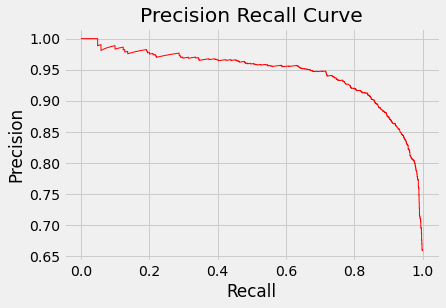

In [51]:
plt.plot(recall, precision, 'r', linewidth=1);
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision');

We have a steep slope which indicates a good performance of the classifier. 

### Tuning Multinomial Naive Bayes using count vectorizer and bigram to four-gram 

This may reduce the pr_auc score but the features will be much more interpretable.

In [52]:
df_txt_cv_bi = text_vectorize(df_train['clean_review'], 
                                     tfidf = False,
                                     min_df= 20, 
                                     ngram_range = (2,4))

X_train_bi = pd.concat([df_txt_cv_bi, df_dummy_company], axis =1)
X_train_bi.shape

(7980, 281)

In [53]:
%%time
cv_mb_bi = RandomizedSearchCV(clf_mb, 
                           param_distributions=mb_param_dists, 
                           scoring = 'average_precision',
                           n_iter=mb_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)

cv_mb_bi.fit(X_train_bi, y_train)

Wall time: 723 ms


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=79, shuffle=True),
                   estimator=MultinomialNB(), n_iter=20, n_jobs=-2,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016285E84508>},
                   random_state=79, scoring='average_precision')

In [54]:
cv_mb_bi_results = pd.DataFrame(cv_mb_bi.cv_results_)
cv_mb_bi_results.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
19,0.049861,0.003257,0.014960,0.002820,0.116208,{'alpha': 0.11620835092990324},0.902337,0.903035,0.904180,0.903184,0.000760,1
16,0.066821,0.002154,0.021944,0.000818,0.140622,{'alpha': 0.1406220144178179},0.902447,0.902951,0.904071,0.903156,0.000679,2
5,0.061501,0.003289,0.020944,0.002155,0.192955,{'alpha': 0.1929550398128653},0.902608,0.902914,0.903872,0.903131,0.000538,3
18,0.060171,0.005422,0.015625,0.003391,0.231218,{'alpha': 0.23121848058126562},0.902739,0.902861,0.903742,0.903114,0.000447,4
9,0.064826,0.004533,0.023272,0.001694,0.081343,{'alpha': 0.08134276174546005},0.902037,0.903118,0.904185,0.903113,0.000877,5


In [55]:
cv_mb_bi.best_score_

0.9031840177064505

In [56]:
cv_mb_bi.best_params_

{'alpha': 0.11620835092990324}

Feature Importance :

In [57]:
x = np.eye(X_train_bi.shape[1])
probs = cv_mb_bi.best_estimator_.predict_proba(x)[:, 1]
ind = np.argsort(probs)

positive_words = X_train_bi.columns[ind[:15]]
negative_words = X_train_bi.columns[ind[-15:]]

positive_prob = probs[ind[:15]]
negative_prob = probs[ind[-15:]]

In [58]:
top_15_imp_negative = pd.DataFrame(zip(negative_words, negative_prob), columns=['words','P(Negative | word)'])
top_15_imp_negative.sort_values(by='P(Negative | word)', ascending=False)

,words,P(Negative | word)
14,slow app,0.998066
13,pout face,0.997152
12,app open,0.997053
11,third class,0.997000
10,keep load,0.996946
9,class app,0.996429
8,far well,0.996272
7,app work properly,0.996188
6,loading loading,0.995472
5,time open,0.995215


In [59]:
top_15_imp_positive = pd.DataFrame(zip(positive_words, positive_prob), columns=['words','P(Negative | word)'])
top_15_imp_positive

,words,P(Negative | word)
0,smile face,0.000849
1,smile face smile,0.001108
2,smile face smile eye,0.001660
3,doctor service,0.002041
4,app thank,0.002339
5,face smile,0.019022
6,smile eye,0.027706
7,face smile eye,0.027706
8,app easy use,0.031961
9,fast service,0.036787


We largely have similar features in importance. The issue of customers saying "company is __fraud__" needs to be addressed on priority. 

### Seperate Modelling for HDFC Ergo  
HDFC Ergo app is rated negatively and  the company name is amongst the top negative feature in logistic regression. Hence, we will seperately model it.

In [60]:
hdfc_ind = X_train.hdfc_ergo == 1

In [61]:
cv_mb.fit(df_txt_cv_feat.loc[hdfc_ind,:], y_train[hdfc_ind])

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=79, shuffle=True),
                   estimator=MultinomialNB(), n_iter=20, n_jobs=-2,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016285E84508>},
                   random_state=79, scoring='average_precision')

In [62]:
hdfc_mb_results = pd.DataFrame(cv_mb.cv_results_)
hdfc_mb_results.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
18,0.014626,0.000469,0.006981,1.410346e-03,0.231218,{'alpha': 0.23121848058126562},0.968251,0.961108,0.970065,0.966474,0.003866,1
5,0.013631,0.000470,0.006649,4.697969e-04,0.192955,{'alpha': 0.1929550398128653},0.968123,0.961129,0.970081,0.966444,0.003842,2
16,0.016290,0.000470,0.007978,2.247832e-07,0.140622,{'alpha': 0.1406220144178179},0.967856,0.961227,0.970164,0.966415,0.003788,3
19,0.010969,0.001411,0.004655,4.702466e-04,0.116208,{'alpha': 0.11620835092990324},0.967697,0.961107,0.970228,0.966344,0.003844,4
9,0.022939,0.006664,0.010306,1.693970e-03,0.081343,{'alpha': 0.08134276174546005},0.967330,0.960898,0.970320,0.966182,0.003931,5


In [63]:
cv_mb.best_score_

0.9664744434292802

In [64]:
cv_mb.best_params_

{'alpha': 0.23121848058126562}

In [65]:
x = np.eye(df_txt_cv_feat.shape[1])
probs = cv_mb.best_estimator_.predict_proba(x)[:, 1]
ind = np.argsort(probs)

positive_words = df_txt_cv_feat.columns[ind[:15]]
negative_words = df_txt_cv_feat.columns[ind[-15:]]

positive_prob = probs[ind[:15]]
negative_prob = probs[ind[-15:]]

In [66]:
top_15_imp_negative = pd.DataFrame(zip(negative_words, negative_prob), columns=['words','P(Negative | word)'])
top_15_imp_negative.sort_values(by='P(Negative | word)', ascending=False)

,words,P(Negative | word)
14,slow app,0.995101
13,show policy,0.994485
11,work properly,0.993792
12,nothing,0.993792
10,app show,0.993590
9,already,0.993375
8,enter,0.993024
7,long,0.992349
6,hai,0.991343
5,back,0.991149


In [67]:
top_15_imp_positive = pd.DataFrame(zip(positive_words, positive_prob), columns=['words','P(Negative | word)'])
top_15_imp_positive.sort_values(by = 'P(Negative | word)')

,words,P(Negative | word)
0,thank,0.108865
1,easy use,0.122818
2,easy,0.178878
3,app easy,0.194897
4,quick,0.273719
5,free,0.283216
6,happy,0.386349
7,fast,0.401967
8,friendly,0.420715
9,thumb,0.421605


In [68]:
y_test_hdfc = df_test.loc[hdfc_ind,'rating']
y_pred_prob_hdfc = cv_mb.best_estimator_.predict_proba(df_test_txt_features.loc[hdfc_ind,])[:,1]

average_precision_score(y_test_hdfc, y_pred_prob_hdfc)

0.9150836187686486

Important predictors of sentiemnts for HDFC Ergo are same as Industry level important features.

### Seperate Modelling for Acko  
Acko app is rated negatively and  the company name is amongst the top negative feature in logistic regression. Hence, we will seperately model it.

In [69]:
acko_ind = X_train.acko == 1

In [70]:
cv_mb.fit(df_txt_cv_feat.loc[acko_ind,:], y_train[acko_ind])

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=79, shuffle=True),
                   estimator=MultinomialNB(), n_iter=20, n_jobs=-2,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016285E84508>},
                   random_state=79, scoring='average_precision')

In [71]:
acko_mb_results = pd.DataFrame(cv_mb.cv_results_)
acko_mb_results.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
18,0.006982,2.973602e-07,0.003989,9.602742e-07,0.231218,{'alpha': 0.23121848058126562},0.904432,0.890901,0.822173,0.872502,0.036014,1
5,0.007978,8.146856e-04,0.006649,4.698533e-04,0.192955,{'alpha': 0.1929550398128653},0.904286,0.891056,0.821963,0.872435,0.036095,2
1,0.009973,1.946680e-07,0.005984,7.370010e-07,0.745195,{'alpha': 0.7451946079635787},0.902360,0.891527,0.821156,0.871681,0.035999,3
13,0.008315,9.362222e-04,0.005315,1.247809e-03,0.956894,{'alpha': 0.9568942444648805},0.901459,0.891429,0.821944,0.871611,0.035358,4
19,0.006315,9.413361e-04,0.003324,4.691790e-04,0.116208,{'alpha': 0.11620835092990324},0.904605,0.890244,0.819764,0.871538,0.037076,5


In [72]:
cv_mb.best_score_

0.8725020954583207

In [73]:
cv_mb.best_params_

{'alpha': 0.23121848058126562}

In [74]:
x = np.eye(df_txt_cv_feat.shape[1])
probs = cv_mb.best_estimator_.predict_proba(x)[:, 1]
ind = np.argsort(probs)

positive_words = df_txt_cv_feat.columns[ind[:15]]
negative_words = df_txt_cv_feat.columns[ind[-15:]]

positive_prob = probs[ind[:15]]
negative_prob = probs[ind[-15:]]

In [75]:
top_15_imp_negative = pd.DataFrame(zip(negative_words, negative_prob), columns=['words','P(Negative | word)'])
top_15_imp_negative.sort_values(by='P(Negative | word)', ascending=False)

,words,P(Negative | word)
14,app work,0.985771
13,load,0.981629
10,wait,0.975745
11,properly,0.975745
12,register,0.975745
9,crash,0.967388
8,message,0.964314
6,reply,0.960601
7,hang,0.960601
4,work properly,0.950246


In [76]:
top_15_imp_positive = pd.DataFrame(zip(positive_words, positive_prob), columns=['words','P(Negative | word)'])
top_15_imp_positive.sort_values(by = 'P(Negative | word)')

,words,P(Negative | word)
0,quick,0.002749
1,easy,0.004273
2,easy use,0.005565
3,app easy,0.009185
4,fast,0.029806
5,happy,0.035833
6,simple,0.036245
7,friendly,0.045673
8,thank,0.069566
9,user friendly,0.072535


In [77]:
y_test_acko = df_test.loc[acko_ind,'rating']
y_pred_prob_acko = cv_mb.best_estimator_.predict_proba(df_test_txt_features.loc[acko_ind,])[:,1]

average_precision_score(y_test_acko, y_pred_prob_acko)

0.9024630716482509

Important predictors of sentiemnts for Acko are same as Industry level important features.

## Business Insights

1. Companies need to investigate why some customers are facing slowness of apps. Is it because the app is heavy on memory or needs fast internet connection.
2. Customers faced issues in receiving OTP and some were not able add or link insurance policies in the app. Better integration with backend IT infrastructure can solve this issue.
3. Companies can increase the adaptation of mobile applications by making customers aware of the applications and benefits. This initiative was well received by customers as we have seen with ICICI Lombard.
4. Value added services like tele consultation with doctors can definitely boost the positive experience of customers in case of health insurance.